# Time Series Analysis

In [1]:
import pandas as pd
import numpy as np
import statsmodels as sm


import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams

import warnings
from random import shuffle

In [2]:
# wide figures 

# warnings 
warnings.filterwarnings("ignore")

In [3]:
large = 19

params = {
    'axes.titlesize'   : large,
    'legend.fontsize'  : large,
    'figure.figsize'   : (14,6),
    'axes.labelsize'   : large,
    'axes.titlesize'   : large,
    'xtick.labelsize'  : large,
    'ytick.labelsize'  : large,
    'figure.titlesize' : large,
    'lines.linewidth'  : 3.0
}
plt.rcParams.update(params) 
plt.style.use('seaborn-whitegrid')

_ = plt.xkcd()

In [4]:
df = pd.read_csv('data/AirPassengers.csv', index_col='date', parse_dates=True)
df.head(3)

,traffic
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132


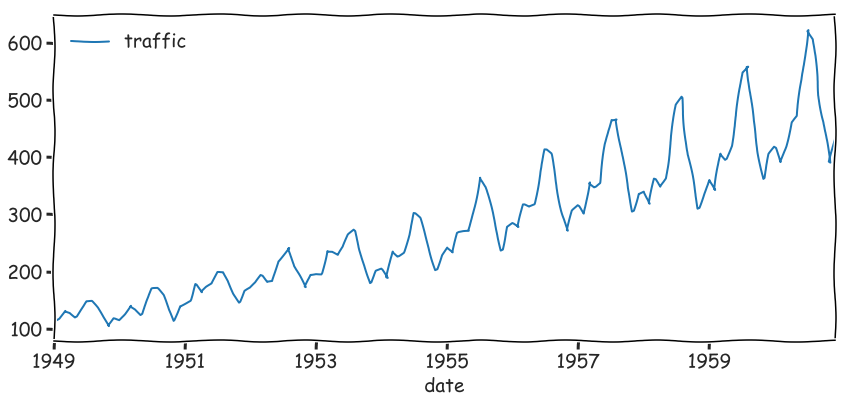

In [5]:
_ = df.plot(figsize=(14,6))

## Seasonal Decomposition 

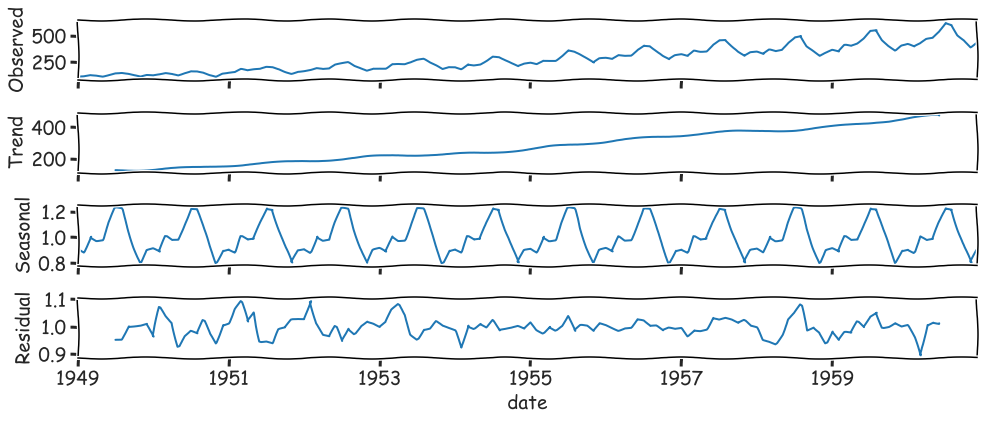

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

results = seasonal_decompose(df.traffic, model="multiplocative")
_ = results.plot()

## Exponential Moving Average (Simple, Double and Triple)

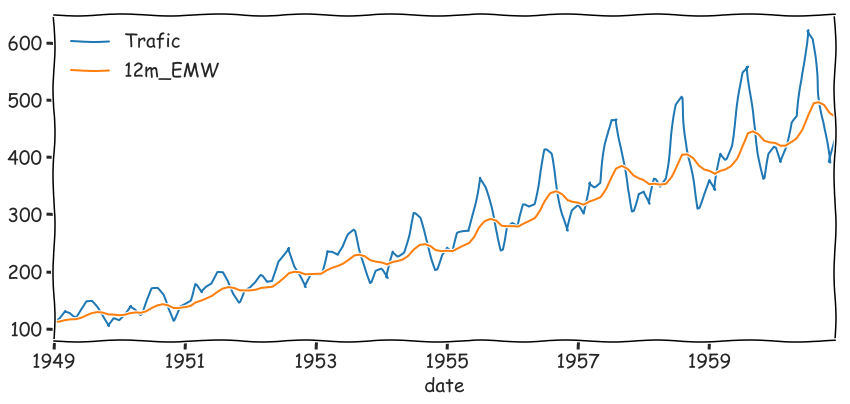

In [7]:
ma = pd.DataFrame()
ma['Trafic'] = df.traffic
# ma['6m_SMA']  = ma['Trafic'].rolling(window=6).mean()
# ma['12m_SMA'] = ma['Trafic'].rolling(window=12).mean()
ma['12m_EMW'] = ma['Trafic'].ewm(span=12,adjust=False).mean()
_ = ma.plot()

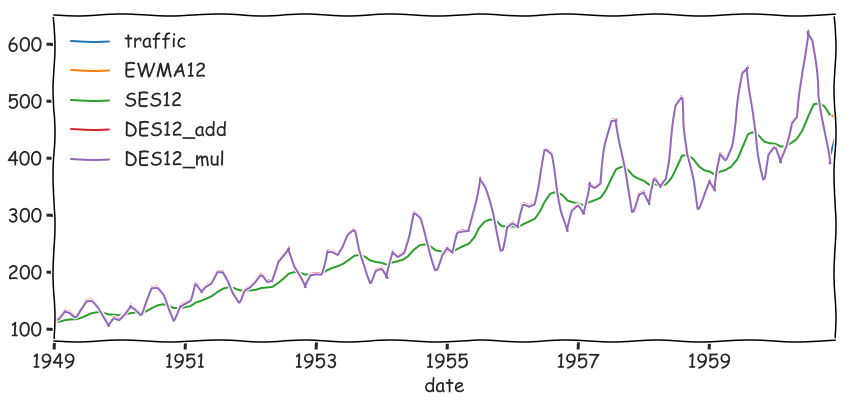

In [8]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

alpha = 2/(12+1)

ma = df.copy() 
ma.index.freq = 'MS'
ma['EWMA12'] = df.traffic.ewm(alpha=alpha,adjust=False).mean()
# simple exponential smoothing.
ma['SES12']  = SimpleExpSmoothing(df.traffic) \
                        .fit(smoothing_level=alpha,optimized=False) \
                        .fittedvalues.shift(-1)
ma['DES12_add']  = ExponentialSmoothing(df.traffic, trend='add') \
                        .fit().fittedvalues.shift(-1)
ma['DES12_mul']  = ExponentialSmoothing(df.traffic, trend='mul') \
                        .fit().fittedvalues.shift(-1)

_ = ma.plot()

detailed view

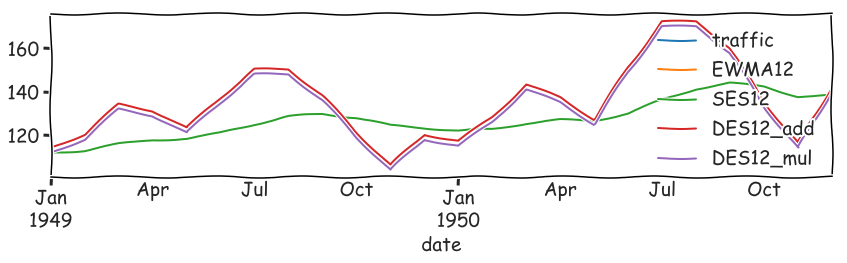

In [9]:
ma.iloc[:24].plot(figsize=(14,3)).autoscale(axis='x',tight=True)

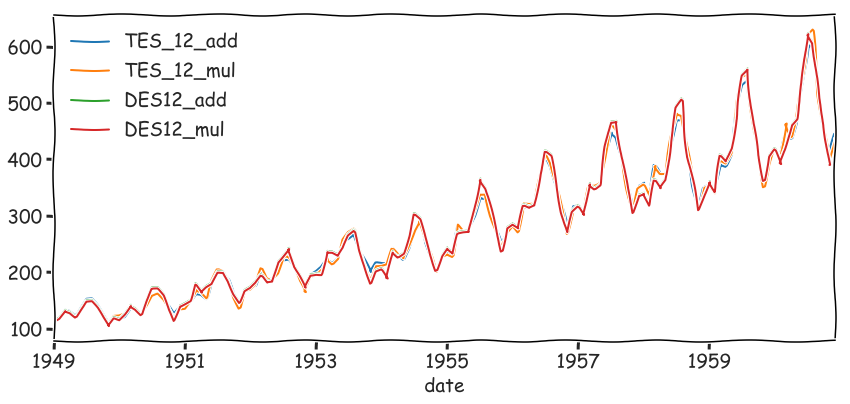

In [10]:
# Triple Exponential Smoothing
ma['TES_12_add'] = ExponentialSmoothing(ma.traffic, trend='add',seasonal='add',seasonal_periods=12) \
                .fit().fittedvalues

ma['TES_12_mul'] = ExponentialSmoothing(ma.traffic, trend='mul',seasonal='mul',seasonal_periods=12) \
                .fit().fittedvalues

_ = ma[['TES_12_add', 'TES_12_mul', 'DES12_add', 'DES12_mul']].plot()

Detailed view

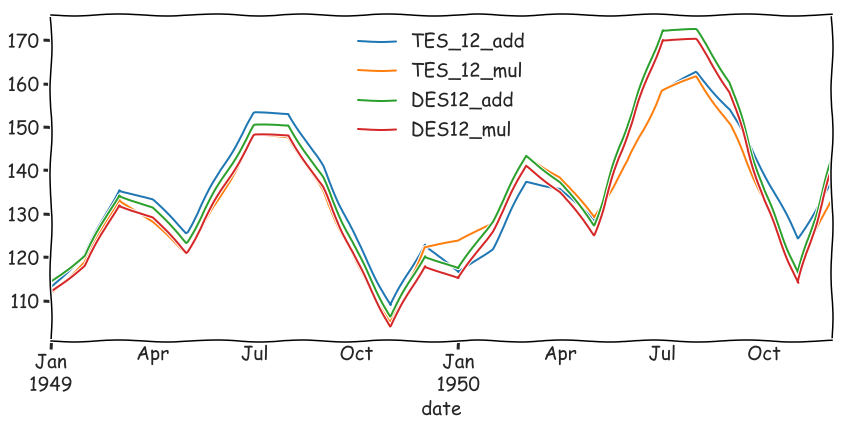

In [11]:
part = ma[['TES_12_add', 'TES_12_mul', 'DES12_add', 'DES12_mul']].iloc[:24]
_ = part.plot(figsize=(14,6)).autoscale(axis='x',tight=True)

## Evaluating Predictions

* Mean Absolute Error
* Mean Squared Error
* Root Mean Square Error

$y$ - real data, $\hat{y}$ - prediction.

### `MAE` Mean Absolute Error 

$\dfrac{1}{n} \sum\limits_{i=1}^n |y_i-\hat{y}_i|$

### `MSE` Mean Squared Error

$\dfrac{1}{n} \sum\limits_{i=1}^n (y_i-\hat{y}_i)^2$

### `RMSE` Root Mean Square Error

$\sqrt{\dfrac{1}{n} \sum\limits_{i=1}^n (y_i-\hat{y}_i)^2}$

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [13]:
split = int(len(df.traffic)*.4)
train, test = df.traffic[:split], df.traffic[split:]

In [14]:
## Exponential Smoothing
model = ExponentialSmoothing(train, trend='mul', seasonal='mul', seasonal_periods=12).fit()

In [15]:
predictions = model.forecast(len(test)).rename('HW Forecast')

In [16]:
predictions.head(3)

1953-10-01    216.577790
1953-11-01    192.472637
1953-12-01    221.219106
Freq: MS, Name: HW Forecast, dtype: float64

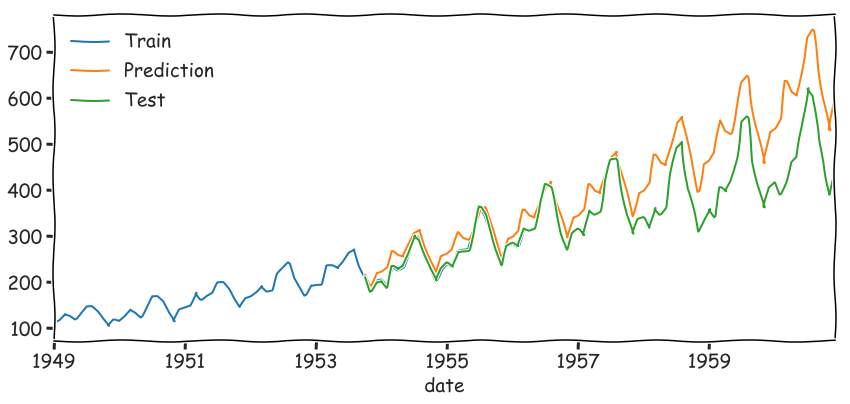

In [17]:
df.traffic[:len(test)].plot(legend=True,label='Train')
predictions.plot(legend=True,label='Prediction')
_ = test.plot(legend=True,label='Test')

In [18]:
items = {
    'MAE': mean_absolute_error(test, predictions),
    'MSE': mean_squared_error(test, predictions),
    'RMSE': mean_absolute_error(test, predictions)**.5,
}

for k, v in items.items(): print("{:<5}: {:<6.4f}".format(k,v))

MAE  : 62.5581
MSE  : 6510.0606
RMSE : 7.9094


In [19]:
test.describe()

count     87.000000
mean     352.333333
std       97.477209
min      180.000000
25%      277.500000
50%      347.000000
75%      410.000000
max      622.000000
Name: traffic, dtype: float64

### Stationary Data - `no trends`, `no seasonality`

* [Forecasting: Principles and Practice](https://otexts.com/fpp2/stationarity.html)

**_Differencing_** 
Non-stationary data can be made to look stationary through differencing. A simple method called first order differencing calculates the difference between consecutive observations.

$y^{\prime}_t = y_t - y_{t-1}$

In [20]:
from statsmodels.tsa.statespace.tools import diff

In [21]:
dfs = pd.read_csv('data/2001rts1.txt', header=None, names=['s1'])

# First order Difference
# same as 
# dfs['s2'] = dfs['s1'] - dfs['s1'].shift(1)
dfs['s2'] = diff(dfs['s1'], k_diff=1)
dfs.head(3)

,s1,s2
0,131.02,NaN
1,142.15,11.13
2,145.68,3.53


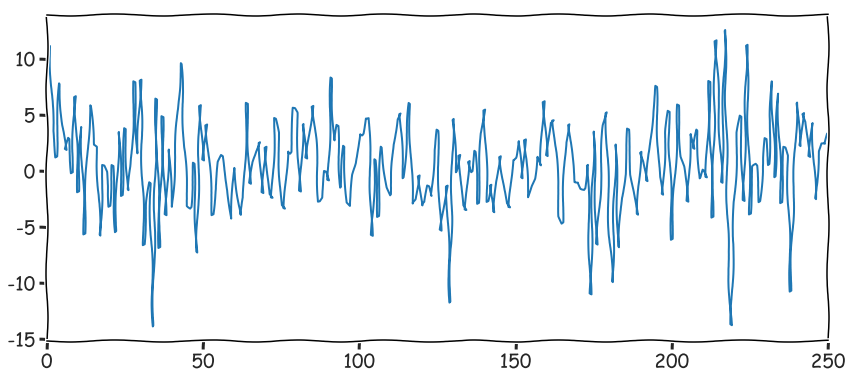

In [22]:
# no stationarity
_ = dfs['s2'].plot()

## ACF and PACF

In [23]:
from statsmodels.tsa.api import pacf as PACF 
from statsmodels.tsa.api import acf as  ACF 
import statsmodels.graphics.tsaplots as tsaplots 

In [24]:
def acf_pacf(y, extra=[], lags=None, figsize=(21,16), chart=None, title=None):
    """ малює серію та графіки акф та чакф"""

    fig = plt.figure(figsize=figsize)
    layout = (2, 2)

    ts_ax   = plt.subplot2grid(layout, (0, 0), colspan=2, rowspan=1)
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    if not title:
        title = 'Time Series'
    ts_ax.set_title(title)
    ts_ax.plot(y, color="r")
    
    y_avg = (y.max() - y.min()) / 10
    y_s, y_e = 0 if y.min() - y_avg > 0 else y.min() - y_avg, y.max()+y_avg
    ts_ax.set_ylim(y_s, y_e)
    ts_ax.set_xlim(0, len(y))
     
#     bgcm ykw
    colors = list('bgcmk')
    shuffle(colors)
        
    for i in range(len(extra)):
        ts_ax.plot(extra[i][0], color=colors[i], label=extra[i][1])
    
    ts_ax.legend(loc="best")
    
    _acf  = ACF(y, nlags=lags)
    _pacf = PACF(y, nlags=lags)
    
    y_max = (_acf.max() if _acf.max() > _pacf.max() else _pacf.max()) + .1
    y_min = (_acf.min() if _acf.min() < _pacf.min() else _pacf.min()) - .5
    
    tsaplots.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05, title="Autocorelation")
    acf_ax.set_ylim(y_min, y_max)
    tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05, title="Partial Autocorelations")
    pacf_ax.set_ylim(y_min, y_max)
    fig.tight_layout()

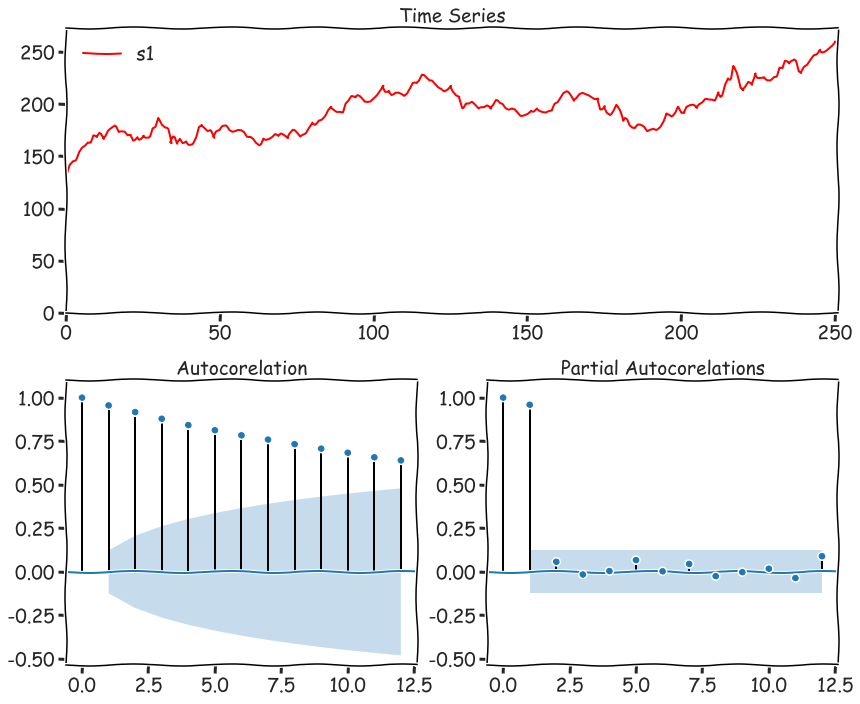

In [25]:
acf_pacf(dfs.s1, figsize=(12,10),  lags=12)

## ARIMA Model


We'll investigate a variety of different forecasting models in upcoming sections, but they all stem from ARIMA.

**ARIMA**, or <em>Autoregressive Integrated Moving Average</em> is actually a combination of 3 models:
* **AR(p)** Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period
* **I(d)** Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
* **MA(q)** Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

----

* **Moving Averages** we've already seen with EWMA and the Holt-Winters Method. 
* **Integration** will apply differencing to make a time series stationary, which ARIMA requires. 
* **Autoregression** is explained in detail in the next section. Here we're going to correlate a current time series with a lagged version of the same series. 
Once we understand the components, we'll investigate how to best choose the $p$, $d$ and $q$ values required by the model.

### Lag Plot

Text(0.5, 1.0, 'Data With Trends - Non Stationary Data')

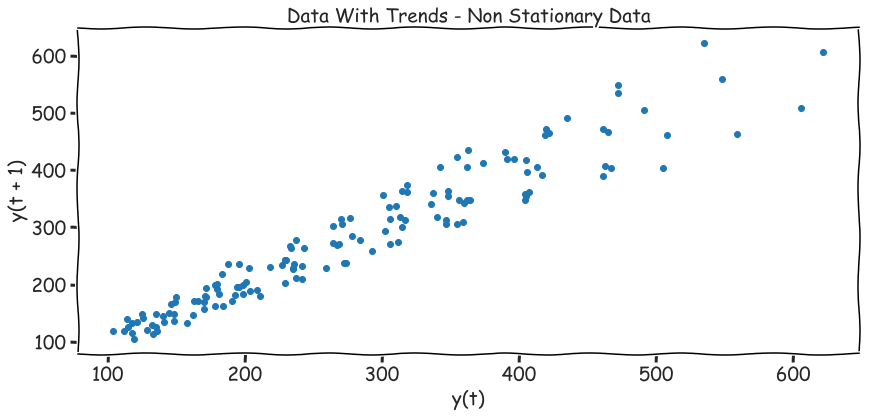

In [26]:
ax = pd.plotting.lag_plot(df.traffic)
ax.set_title("Data With Trends - Non Stationary Data")

Text(0.5, 1.0, 'Stationary (residuals of s1)')

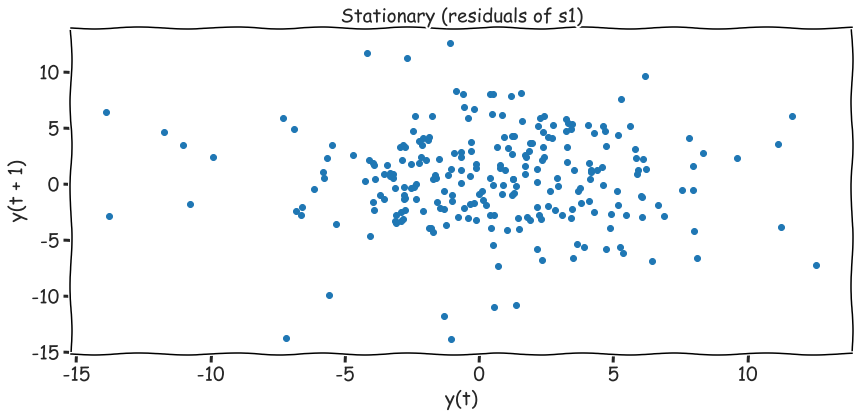

In [27]:
ax = pd.plotting.lag_plot(dfs.s2)
ax.set_title("Stationary (residuals of s1)")